In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid based SEPP method(s)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

# With real data

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import opencrimedata.chicago
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [5]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

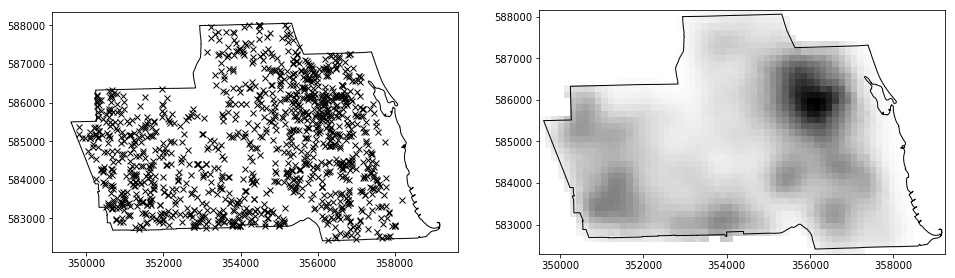

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

In [8]:
def add_random_noise(points):
    return points
    #ts = points.timestamps + np.random.random(size=points.timestamps.shape) * 60 * 1000 * np.timedelta64(1,"ms")
    #ts = np.sort(ts)
    #return points.from_coords(ts, points.xcoords, points.ycoords)

In [9]:
trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1, timeunit=datetime.timedelta(days=1))
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)

In [10]:
model

ExpDecayModel(T=365.9583333333333, theta=0.0011706188705297804, omega=16.70686652635268, mu size=(39, 65), t0=1

In [11]:
pred = trainer.prediction_from_background(model)

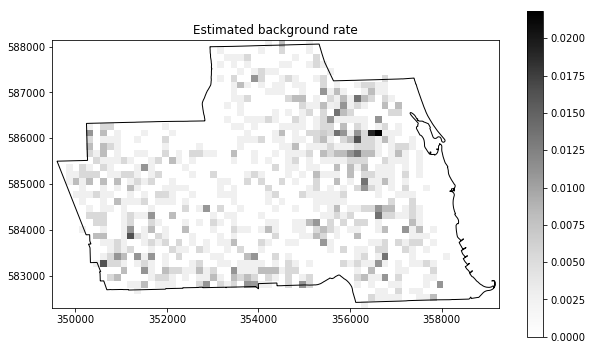

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Estimated background rate")
None

In [13]:
np.max(model.mu), np.min(model.mu)

(0.021860412092214669, 0.0)

In [14]:
24 * 60 / model.omega

86.192105367491081

Unfortunately, the predicted parameters are not very "realistic", because $\theta$ is small, and $\omega$ indicates a very fast repeat time.

In [15]:
trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1, timeunit=datetime.timedelta(days=1))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)

In [16]:
model

ExpDecayModel(T=365.9583333333333, theta=0.0011706381528310435, omega=16.70621616366923, mu size=(39, 65), t0=1

In [17]:
24 * 60 / model.omega

86.195460772951535

# Other regions of chicago

Notice how small $\theta$ gets!

In [18]:
sides = ["Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"]

In [19]:
def load(side):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= np.datetime64("2010-01-01")) & (all_points.timestamps < np.datetime64("2011-01-01"))
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points

def train(grid, points):
    trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1)
    trainer.data = add_random_noise(points)
    model = trainer.train(datetime.datetime(2011,1,1), iterations=50)
    return model

In [20]:
for side in sides:
    model = train(*load(side))
    print(side, model.theta, 1/model.omega, np.max(model.mu))

Far North 2.08528440274e-18 10.7103581965 0.0246631651062
Northwest 5.07311159703e-17 7.05621306775 0.0274102978966
North 1.19188126277e-07 1.27011696467 0.0328804616758
West 0.000142070706102 0.0287653783923 0.0383561643824
Central 1.58748556797e-14 11.5693841666 0.0192295585786
South 0.00315732483487 0.12300286657 0.046573384338
Southwest 3.01178013896e-09 0.516631595321 0.0438356158605
Far Southwest 9.48697535019e-12 1.1581989172 0.0411381556393
Far Southeast 3.35004551075e-06 0.184653501925 0.0494020627874


# Vary the `cutoff`

Computationally expensive.

In [21]:
grid, points = load("South")

In [22]:
trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1)
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2011,1,1), iterations=50)
model

ExpDecayModel(T=365.0, theta=0.00315732483486798, omega=8.129891830017828, mu size=(80, 70), t0=1

In [23]:
model = trainer.train(datetime.datetime(2011,1,1), iterations=100)
model

ExpDecayModel(T=365.0, theta=0.0020513888203208294, omega=24.395785277503922, mu size=(80, 70), t0=1

In [24]:
model = trainer.train(datetime.datetime(2011,1,1), iterations=200)
model

ExpDecayModel(T=365.0, theta=0.0020489100047152726, omega=24.46690058767375, mu size=(80, 70), t0=1

In [25]:
cutoff = [0.1, 0.2, 0.5, 1, 1.5, 2]
lookup = {}
for c in cutoff:
    trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=c)
    trainer.data = add_random_noise(points)
    model = trainer.train(datetime.datetime(2011,1,1), iterations=100)
    lookup[c] = model

In [26]:
lookup

{0.1: ExpDecayModel(T=365.0, theta=0.007482802771122155, omega=2.442712293342475, mu size=(80, 70), t0=0.1,
 0.2: ExpDecayModel(T=365.0, theta=0.004787608984395658, omega=4.642818321841674, mu size=(80, 70), t0=0.2,
 0.5: ExpDecayModel(T=365.0, theta=0.0029602573306258487, omega=1.1767043598920761, mu size=(80, 70), t0=0.5,
 1: ExpDecayModel(T=365.0, theta=0.0020513888203208294, omega=24.395785277503922, mu size=(80, 70), t0=1,
 1.5: ExpDecayModel(T=365.0, theta=1.5758028726785033e-06, omega=1.1181501853655058, mu size=(80, 70), t0=1.5,
 2: ExpDecayModel(T=365.0, theta=5.339564040678907e-06, omega=2.267394969560776, mu size=(80, 70), t0=2}

In [27]:
pred = trainer.prediction_from_background(lookup[0.1])
pred.mask_with(grid)
pred = pred.renormalise()

pred1 = trainer.prediction_from_background(lookup[0.5])
pred1.mask_with(grid)
pred1 = pred1.renormalise()

np.max(np.abs(pred.intensity_matrix - pred1.intensity_matrix))

0.00022991046897816636